### Testing dependecies

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import torch
from pydub import AudioSegment
import librosa as lb


c:\Users\charb\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:

p = torch.tensor([[1.1, 2.1, 3.01], [4.1, 5.01, 6.01]])[:1, :2]
p

tensor([[1.1000, 2.1000]])

### We are trying to extract the data from the sample1.mp3 to be able to visualize the data 

In [4]:
Y,sr = lb.load("sample1.mp3")
time = np.arange(start=0,stop=len(Y)/sr,step=1/sr)
sr

22050

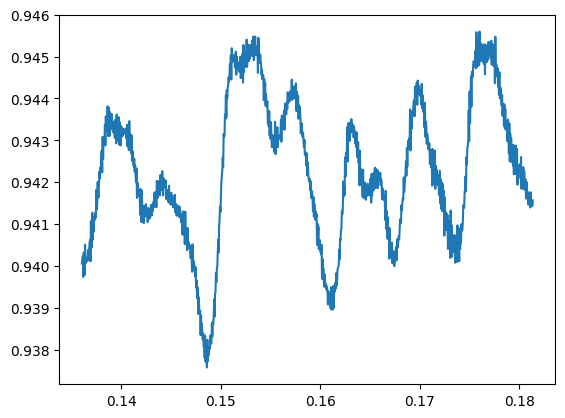

In [4]:
start = 3000
end = 4000
Y_plt = Y - min(Y) # just to see all the values as positive ones
plt.plot(time[start:end],Y_plt[start:end])                      

In [5]:
n_fft = 20040
freq_diff = sr/n_fft
hop_length = 500
time_diff = hop_length/sr
Frequency_domain = lb.stft(Y)
Fd_db = lb.amplitude_to_db(np.abs(Frequency_domain),ref=np.max)
freq_diff,Fd_db.shape,time_diff

(1.1002994011976048, (1025, 23202), 0.022675736961451247)

In [6]:
H = np.abs(lb.stft(Y,hop_length=hop_length,n_fft=n_fft))
H = lb.amplitude_to_db(H)
Melody = lb.feature.melspectrogram(S=H,sr=sr,hop_length=hop_length,win_length=n_fft)
Melody = lb.amplitude_to_db(Melody)
Melody.shape, H.shape

((128, 23758), (10021, 23758))

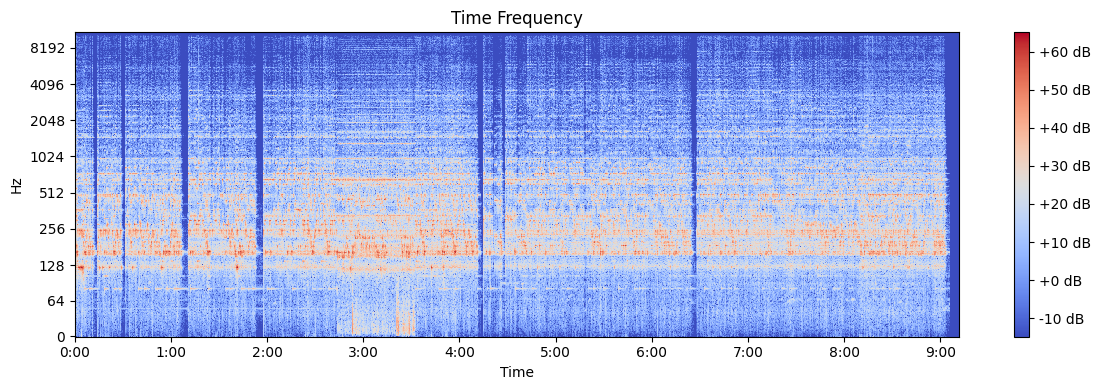

In [7]:
plt.figure(figsize=(12, 4))
lb.display.specshow(H, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Time Frequency')
plt.tight_layout()

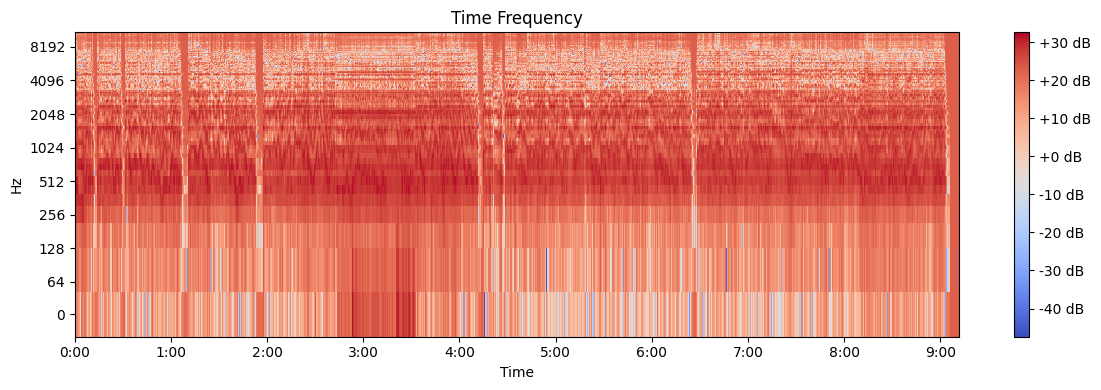

In [7]:

plt.figure(figsize=(12, 4))
start_time = 150
end_time = 180    

hop_length = 512  # default hop_length in librosa
start_frame = int(start_time * sr / hop_length)
end_frame = int(end_time * sr / hop_length)

lb.display.specshow(Melody, x_axis='time', sr=sr,y_axis='log', hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Time Frequency')
plt.tight_layout()

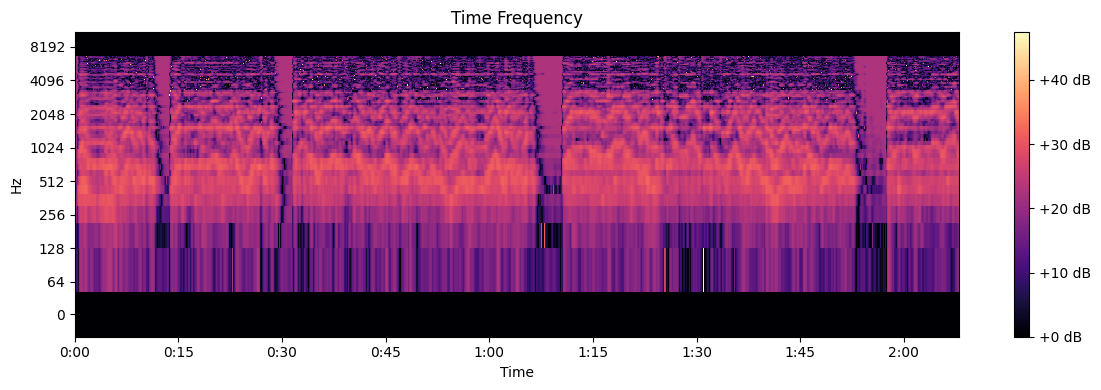

In [8]:
def Fine_tuner(Melody_spectrogram, sr=22050, n_mels=128, fmin=0, fmax=None):
    M_t = Melody_spectrogram.copy()
    mel_freqs = lb.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax or sr//2)
    mask = (mel_freqs < 10) | (mel_freqs > 3000)
    M_t[mask, :] = 0
    return M_t

def draw_spectrogram(data, start_time, end_time, sr,hop_length):
    plt.figure(figsize=(12, 4))
    start_frame = int(start_time * sr / hop_length)
    end_frame = int(end_time * sr / hop_length)
    lb.display.specshow(data[:, start_frame:end_frame], x_axis='time', y_axis='log', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Time Frequency')
    plt.tight_layout()
    plt.show()


draw_spectrogram(Fine_tuner(np.abs(Melody), sr=sr, n_mels=Melody.shape[0]), 0, len(Melody), sr, hop_length)


In [9]:
T = 500
BETAS = torch.linspace(0.001, 0.02, T)  # fixed linespace to linspace
ALPHAS = 1 - BETAS
A_T_BAR = torch.cumprod(ALPHAS, dim=0)  # added dim=0 parameter
sqrt_alphas_epsilon = torch.sqrt(1 - A_T_BAR)
sqrt_alphas_x_0 = torch.sqrt(A_T_BAR)

def get_value_at_index(list_tensor, t, x_shape):
    batch_size = x_shape[0]
    out = list_tensor.gather(-1, t)
    return out.reshape(batch_size, 1, 1)

def forward_noise_q(x_0, t, A1, A2):  # removed redundant T parameter
    noise = torch.randn_like(x_0)  # changed rand_like to randn_like for Gaussian noise
    sqrt_alphas_x_0_t = get_value_at_index(A1, t, x_0.shape)
    sqrt_alphas_epsilon_t = get_value_at_index(A2, t, x_0.shape)
    x_t = sqrt_alphas_x_0_t * x_0 + sqrt_alphas_epsilon_t * noise
    return x_t


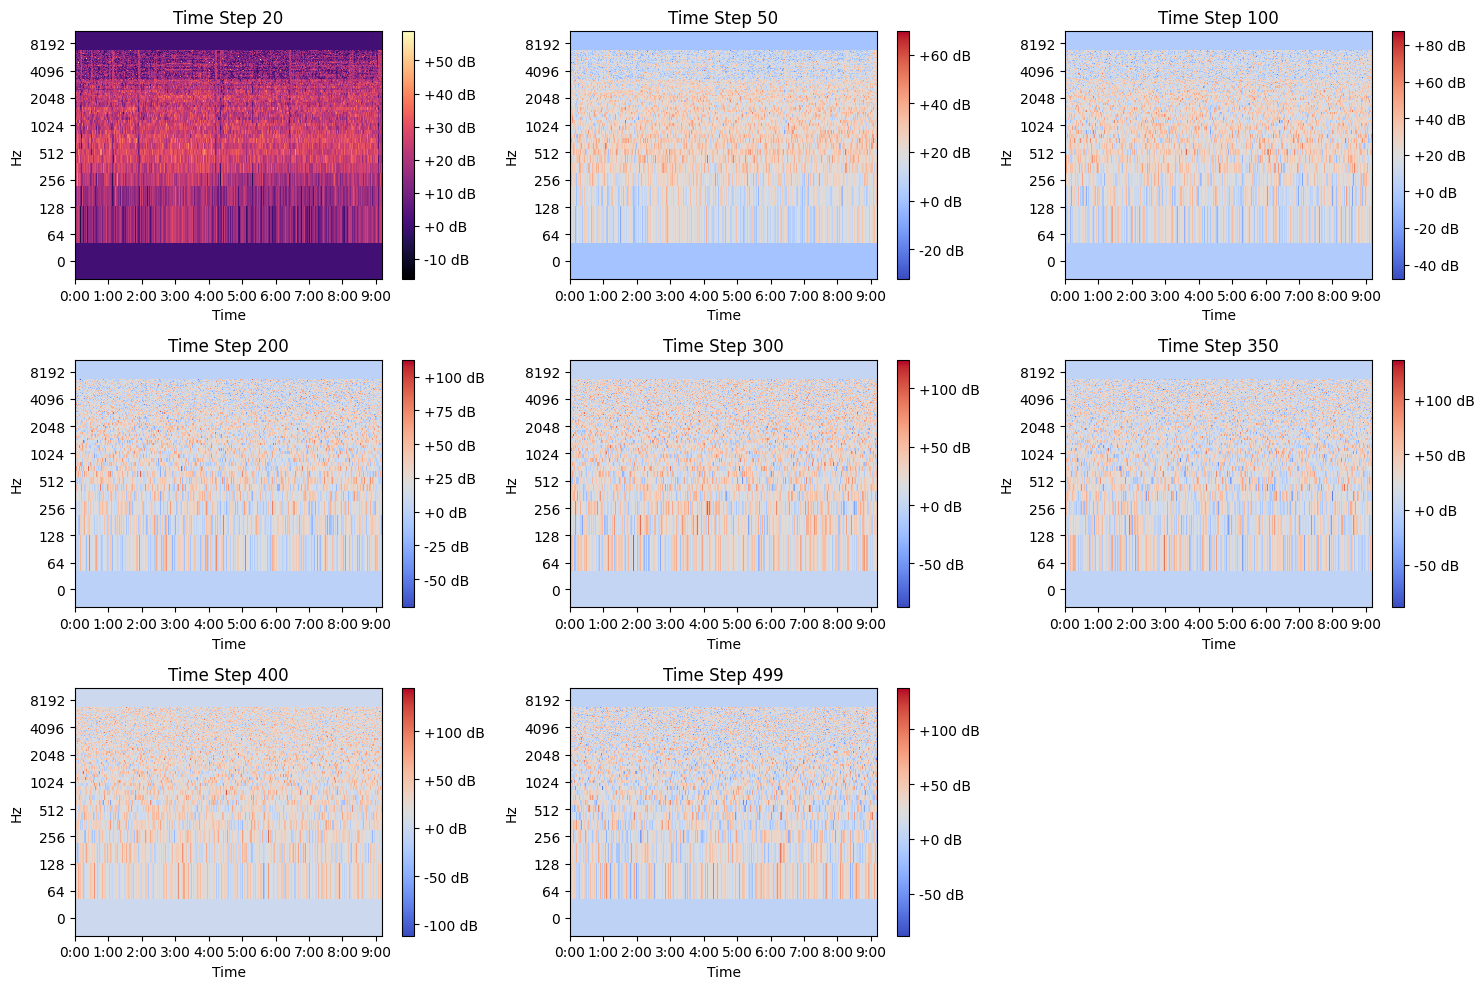

In [ ]:
melody_tensor = torch.from_numpy(np.abs(Melody)).unsqueeze(0).float() 

mel_min = melody_tensor.min()
mel_max = melody_tensor.max()
mel_t = 2 * (melody_tensor - mel_min) / (mel_max - mel_min) - 1

t = torch.tensor([20,50, 100, 200, 300, 350, 400, 499]).long()

plt.figure(figsize=(15, 10))
for i, f in enumerate(t):
    plt.subplot(3, 3, i+1)
    noisy_melody = forward_noise_q(mel_t, f.unsqueeze(0), sqrt_alphas_x_0, sqrt_alphas_epsilon)
    
    noisy_melody_denorm = ((noisy_melody + 1) / 2) * (mel_max - mel_min) + mel_min
    
    lb.display.specshow(Fine_tuner(noisy_melody_denorm.squeeze().numpy(), sr=sr, n_mels=Melody.shape[0]),
                       x_axis='time', y_axis='log', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Time Step {f.item()}')
plt.tight_layout()
plt.show()

## FFT to classify notes 

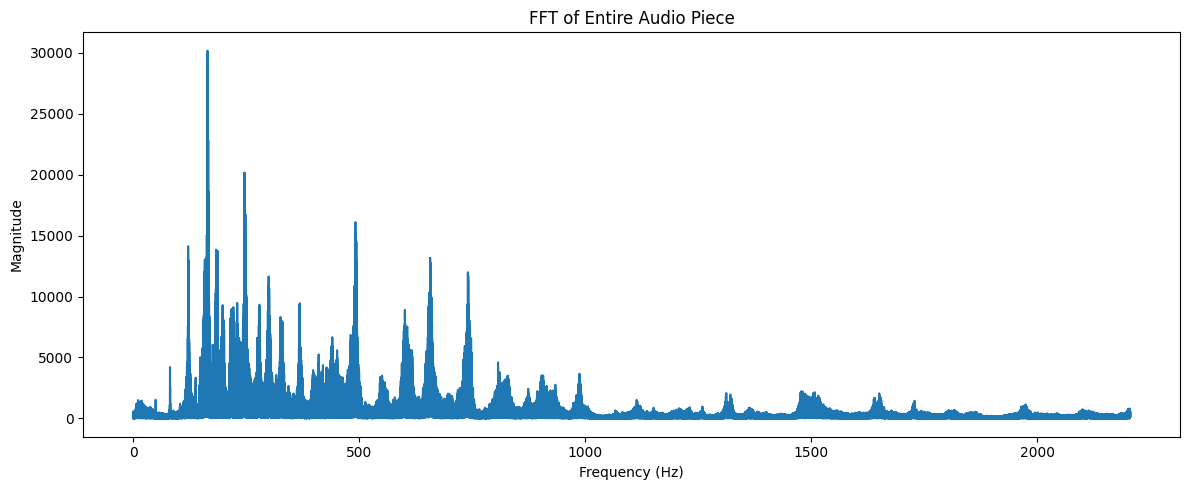

In [ ]:
Y_fft_full = np.fft.fft(Y)
freqs_full = np.fft.fftfreq(len(Y), d=1/sr)

plt.figure(figsize=(12, 5))
plt.plot(freqs_full[:len(Y)//10], np.abs(Y_fft_full[:len(Y)//10]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('FFT of Entire Audio Piece')
plt.tight_layout()
plt.show()

In [ ]:
# these methods and functions enable us to work with data efficiently
def theta_filter(x, alpha):
    if x > alpha:
        return x
    return 0
theta_filter_vec = np.vectorize(theta_filter)

def Psi_filter(X, alpha):
    return theta_filter_vec(X, alpha)

def delta_Gaussian_filter(X,alpha,mu,sigma,epsilon):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, int(epsilon))
    gaussian = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    gaussian /= gaussian.sum()  # Normalize
    X_v = Psi_filter(X,alpha)
    return np.convolve(X_v, gaussian, mode='same')



np.float64(-1585.0575877656136)

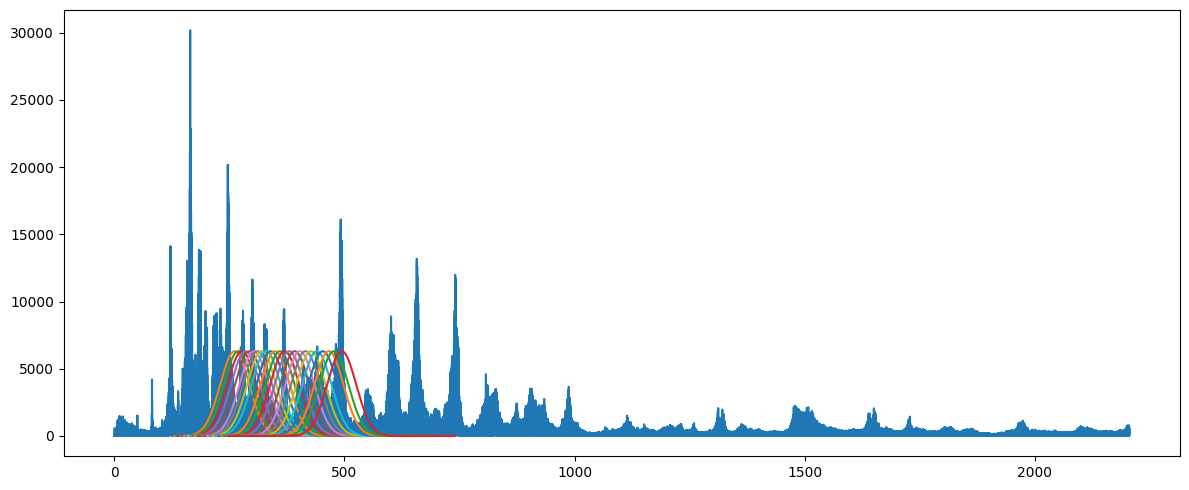

In [ ]:
freq_to_note = {
    261.63: 'C',
    269.29: 'C half-sharp',    
    277.18: 'C# / Db',
    285.00: 'D half-flat',  
    293.66: 'D',
    303.40: 'D half-sharp',  
    311.13: 'D# / Eb',
    320.00: 'E half-flat',    
    329.63: 'E',
    340.00: 'E half-sharp',    
    349.23: 'F',
    360.00: 'F half-sharp',    
    369.99: 'F# / Gb',
    380.00: 'G half-flat',     
    392.00: 'G',
    403.00: 'G half-sharp',    
    415.30: 'G# / Ab',
    427.00: 'A half-flat',  
    440.00: 'A',
    453.00: 'A half-sharp',    
    466.16: 'A# / Bb',
    477.00: 'B half-flat',  
    493.88: 'B'
}

def gaussian_(center,spread,height_scale):
    X = np.linspace(start=center/2,stop=3/2*center,num=1000)
    Y = np.exp(-(X-center)**2/(2*spread))* 1/np.sqrt(2* np.pi* spread)*height_scale
    return(X,Y)
plt.figure(figsize=(12, 5))
plt.plot(freqs_full[:len(Y)//10], np.abs(Y_fft_full[:len(Y)//10]))

for e in freq_to_note:
    d = gaussian_(e,1000,500000)
    plt.plot(d[0],d[1])
plt.tight_layout()

In [15]:
import torch

torch.randint(0,99,(10,)) < 0.5

tensor([False, False, False, False, False, False, False, False, False, False])